<a href="https://colab.research.google.com/github/tikendraw/fake_news_classifier/blob/main/fake_news_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# FAKE NEWS CLASSIFIER : Build a system to identify unreliable news articles
Develop a machine learning program to identify when an article might be fake news. Run by the UTK Machine Learning Club.



## Dataset Description
[Dataset Here](https://www.kaggle.com/competitions/fake-news/code)


**train.csv** : A full training dataset with the following attributes:

* id: unique id for a news article
* title: the title of a news article
* author: author of the news article
* text: the text of the article; could be incomplete
* label: a label that marks the article as potentially unreliable

    1: unreliable
    
    0: reliable

In [1]:
import tensorflow as tf
print(tf.__version__)
print('GPU:',len(tf.config.list_physical_devices('GPU')))

2022-11-11 12:47:40.439007: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-11 12:47:40.927760: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-11 12:47:42.173412: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/t/miniconda3/envs/tf/lib/
2022-11-11 12:47:42.173752: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.

2.10.0
GPU: 0


2022-11-11 12:47:44.045289: E tensorflow/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2022-11-11 12:47:44.045383: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: t
2022-11-11 12:47:44.045407: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: t
2022-11-11 12:47:44.045608: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 515.65.1
2022-11-11 12:47:44.045674: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 515.65.1
2022-11-11 12:47:44.045695: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 515.65.1


In [2]:
# !pip install numpy pandas matplotlib -q
# !pip install nltk textblob -q
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import textblob
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import gensim

# !git clone https://github.com/tikendraw/funcyou.git -q
import funcyou

In [3]:
import re
from sklearn.model_selection import train_test_split

In [4]:
# DOWNLOADING EXTRA FILES
# nltk.download('all')
# !python -m textblob.download_corpora

# GET THE DATA

In [5]:
from funcyou.dataset import download_kaggle_dataset

In [6]:
# IMPORT THE DATA
DATA_LINK = 'https://www.kaggle.com/competitions/fake-news/code'

## uncomment this if don't have data locally 
# download_kaggle_dataset(url = DATA_LINK)              # keep the kaggle.json in current working directory

# UNZIP THE DATA
# !unzip fake-news.zip -d dataset

In [7]:
##OR
# !git clone https://github.com/tikendraw/fake_news_classifier.git -q
# !unzip fake_news_classifier/dataset/train.csv.zip -d dataset

## READ THE DATA

In [8]:
data = pd.read_csv('./dataset/train.csv')
print('datset.shape: ',data.shape)
print('dataset info: ',data.info())

datset.shape:  (20800, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20800 entries, 0 to 20799
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      20800 non-null  int64 
 1   title   20242 non-null  object
 2   author  18843 non-null  object
 3   text    20761 non-null  object
 4   label   20800 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 812.6+ KB
dataset info:  None


In [9]:
data

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1
...,...,...,...,...,...
20795,20795,Rapper T.I.: Trump a ’Poster Child For White S...,Jerome Hudson,Rapper T. I. unloaded on black celebrities who...,0
20796,20796,"N.F.L. Playoffs: Schedule, Matchups and Odds -...",Benjamin Hoffman,When the Green Bay Packers lost to the Washing...,0
20797,20797,Macy’s Is Said to Receive Takeover Approach by...,Michael J. de la Merced and Rachel Abrams,The Macy’s of today grew from the union of sev...,0
20798,20798,"NATO, Russia To Hold Parallel Exercises In Bal...",Alex Ansary,"NATO, Russia To Hold Parallel Exercises In Bal...",1




Here We will be dropping `id` (unique value does not provide any value to 

instance) and `author` (to no create a biasness towards it)

In [10]:
# DROPPING ID AND AUTHOR
data.drop(['id','author'], axis = 1, inplace = True)

In [11]:
data.head(5)

,title,text,label
0,House Dem Aide: We Didn’t Even See Comey’s Let...,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Ever get the feeling your life circles the rou...,0
2,Why the Truth Might Get You Fired,"Why the Truth Might Get You Fired October 29, ...",1
3,15 Civilians Killed In Single US Airstrike Hav...,Videos 15 Civilians Killed In Single US Airstr...,1
4,Iranian woman jailed for fictional unpublished...,Print \nAn Iranian woman has been sentenced to...,1


In [12]:
data.title[0]

'House Dem Aide: We Didn’t Even See Comey’s Letter Until Jason Chaffetz Tweeted It'

# Preprocessing

### Handling Missing values

In [13]:
# CHECK FOR NAN VALUES
data.isnull().sum()

title    558
text      39
label      0
dtype: int64

In [14]:
data.shape

(20800, 3)

In [15]:
# CHECK IF TEXT AND TITLE IS MISSING TOGATHER
data[(data['text'] == np.nan) & (data['title']== np.nan)].shape

(0, 3)

There are no values where both 'text' and 'title' are missing

In [16]:
text_nulls = data[data['text'].isnull()].index.tolist()
title_nulls  = data[data['title'].isnull()].index.tolist()

In [17]:
# VALUE COUNTS OF MISSING TEXT AND TITLE
print('missing title values: ', len(title_nulls))
print('missing title label counts: ', data[data['title'].isnull()]['label'].value_counts())

# VALUE COUNTS OF MISSING TITLE AND TITLE
print('\nmissing text values: ', len(text_nulls))
print('missing TEXT  label counts: ', data[data['text'].isnull()]['label'].value_counts())


missing title values:  558
missing title label counts:  1    558
Name: label, dtype: int64

missing text values:  39
missing TEXT  label counts:  1    39
Name: label, dtype: int64


Here we can see that if either text or title is missing then it is classified as Fake news explicitely

So, we dropping nulls

In [18]:
print('before dropping na: ',data.shape)
data.dropna(axis = 0, inplace = True)
print('after dropping na: ',data.shape)

before dropping na:  (20800, 3)
after dropping na:  (20203, 3)


## Cleaning and Preprocessing


* Replacing Contractions
* removing punctuation
* remove special characters from text column
* Remove digits
* remove "'s"
* Remove www
* remove urls
* remove multiple spaces with single space
* remove all single characters


In [19]:
#@title this is contractions :: too long don't open
contractions_dict = { 
"ain't": "am not / are not / is not / has not / have not",
"aren't": "are not / am not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"didn`t": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he had / he would",
"he'd've": "he would have",
"he'll": "he shall / he will",
"he'll've": "he shall have / he will have",
"he's": "he has / he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how has / how is / how does",
"I'd": "I had / I would",
"I'd've": "I would have",
"I'll": "I shall / I will",
"I'll've": "I shall have / I will have",
"I'm": "I am",
"I've": "I have",
"isn't": "is not",
"it'd": "it had / it would",
"it'd've": "it would have",
"it'll": "it shall / it will",
"it'll've": "it shall have / it will have",
"it's": "it has / it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she had / she would",
"she'd've": "she would have",
"she'll": "she shall / she will",
"she'll've": "she shall have / she will have",
"she's": "she has / she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as / so is",
"that'd": "that would / that had",
"that'd've": "that would have",
"that's": "that has / that is",
"there'd": "there had / there would",
"there'd've": "there would have",
"there's": "there has / there is",
"they'd": "they had / they would",
"they'd've": "they would have",
"they'll": "they shall / they will",
"they'll've": "they shall have / they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we had / we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what shall / what will",
"what'll've": "what shall have / what will have",
"what're": "what are",
"what's": "what has / what is",
"what've": "what have",
"when's": "when has / when is",
"when've": "when have",
"where'd": "where did",
"where's": "where has / where is",
"where've": "where have",
"who'll": "who shall / who will",
"who'll've": "who shall have / who will have",
"who's": "who has / who is",
"who've": "who have",
"why's": "why has / why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you had / you would",
"you'd've": "you would have",
"you'll": "you shall / you will",
"you'll've": "you shall have / you will have",
"you're": "you are",
"you've": "you have"
}

In [20]:
# very necessary function you can't tell differece between "’" and "'", I don't even have that symbol in my keyboard

def text_cleaning_apos(text):
    text = str(text)
    text = text.lower()
    text = re.sub("’", "'", text) # removing punctuation
    return text

In [21]:
# FUNCTIONS TO EXPAND CONTRACTIONS
def cont_to_exp(x):
    x = str(x).lower()
    xsplited = x.split(' ')
    exp_sentence = []
    for s in x.split():
        if s in contractions_dict.keys():
            
            s = contractions_dict.get(s)
        exp_sentence.append(s)
        
    x = ' '.join(exp_sentence)
    return x
#     print(xsplited)
#     return xsplited

In [22]:
%%time
data['text'] = data['text'].apply(text_cleaning_apos)
data['title'] = data['title'].apply(text_cleaning_apos)

data['text'] = data['text'].apply(cont_to_exp)
data['title'] = data['title'].apply(cont_to_exp)

CPU times: user 5.14 s, sys: 86.5 ms, total: 5.22 s
Wall time: 5.22 s


In [23]:
def text_cleaning(text):
    text = str(text)
    text = text.lower()
    text = re.sub("[^a-zA-Z]", " ", text) # removing punctuation
    # remove special characters from text column
    text = re.sub('[#,@,&]', '',text)
    # Remove digits
    text = re.sub('\d*','', text)
    # remove "'s"
    text = re.sub("'s",'', text)
    #Remove www
    text = re.sub('w{3}','', text)
    # remove urls
    text = re.sub("http\S+", "", text)
    # remove multiple spaces with single space
    text = re.sub('\s+', ' ', text)
    #remove all single characters
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)

    return text

In [24]:
%%time
data['title'] = data['title'].apply(text_cleaning) 
data['text'] = data['text'].apply(text_cleaning) 

CPU times: user 23.6 s, sys: 0 ns, total: 23.6 s
Wall time: 23.6 s


In [25]:
data.head()

,title,text,label
0,house dem aide we did not even see comey lette...,house dem aide we did not even see comey lette...,1
1,flynn hillary clinton big woman on campus brei...,ever get the feeling your life circles the rou...,0
2,why the truth might get you fired,why the truth might get you fired october the ...,1
3,civilians killed in single us airstrike have ...,videos civilians killed in single us airstrike...,1
4,iranian woman jailed for fictional unpublished...,print an iranian woman has been sentenced to s...,1


In [26]:
# # Cleaning the words
# lemmatizer = WordNetLemmatizer()

# def nltk_clean(text):
#     text = str(text).lower()
#     text = [lemmatizer.lemmatize(word) for word in word_tokenize(text) if word not in stopwords.words('english')]
#     text = ' '.join(text)
#     return text

In [27]:
# %%time

# # takes alot of time
# data['title'] = data['title'].apply(nltk_clean) 
# data['text'] = data['text'].apply(nltk_clean) 

In [28]:
data.head()

,title,text,label
0,house dem aide we did not even see comey lette...,house dem aide we did not even see comey lette...,1
1,flynn hillary clinton big woman on campus brei...,ever get the feeling your life circles the rou...,0
2,why the truth might get you fired,why the truth might get you fired october the ...,1
3,civilians killed in single us airstrike have ...,videos civilians killed in single us airstrike...,1
4,iranian woman jailed for fictional unpublished...,print an iranian woman has been sentenced to s...,1


In [29]:
data.title[0]

'house dem aide we did not even see comey letter until jason chaffetz tweeted it'

# Feature Engineering

In [30]:
data['title_len'] = data['title'].apply(lambda x: len(str(x).split(' ')))
data['text_len'] = data['text'].apply(lambda x: len(str(x).split(' ')))
data['title_text_ratio'] = data['title_len']/data['text_len']
# train['avg_title_len'] = train['title'].apply(lambda x: len(str(x).split()))

In [31]:
data

,title,text,label,title_len,text_len,title_text_ratio
0,house dem aide we did not even see comey lette...,house dem aide we did not even see comey lette...,1,15,812,0.018473
1,flynn hillary clinton big woman on campus brei...,ever get the feeling your life circles the rou...,0,8,673,0.011887
2,why the truth might get you fired,why the truth might get you fired october the ...,1,7,1227,0.005705
3,civilians killed in single us airstrike have ...,videos civilians killed in single us airstrike...,1,10,530,0.018868
4,iranian woman jailed for fictional unpublished...,print an iranian woman has been sentenced to s...,1,14,143,0.097902
...,...,...,...,...,...,...
20795,rapper i trump poster child for white supremacy,rapper i unloaded on black celebrities who met...,0,9,296,0.030405
20796,n l playoffs schedule matchups and odds the ne...,when the green bay packers lost to the washing...,0,11,1014,0.010848
20797,macy is said to receive takeover approach by h...,the macy of today grew from the union of sever...,0,14,755,0.018543
20798,nato russia to hold parallel exercises in balkans,nato russia to hold parallel exercises in balk...,1,8,261,0.030651


In [32]:
data.title_len.value_counts

<bound method IndexOpsMixin.value_counts of 0        15
1         8
2         7
3        10
4        14
         ..
20795     9
20796    11
20797    14
20798     8
20799     4
Name: title_len, Length: 20203, dtype: int64>

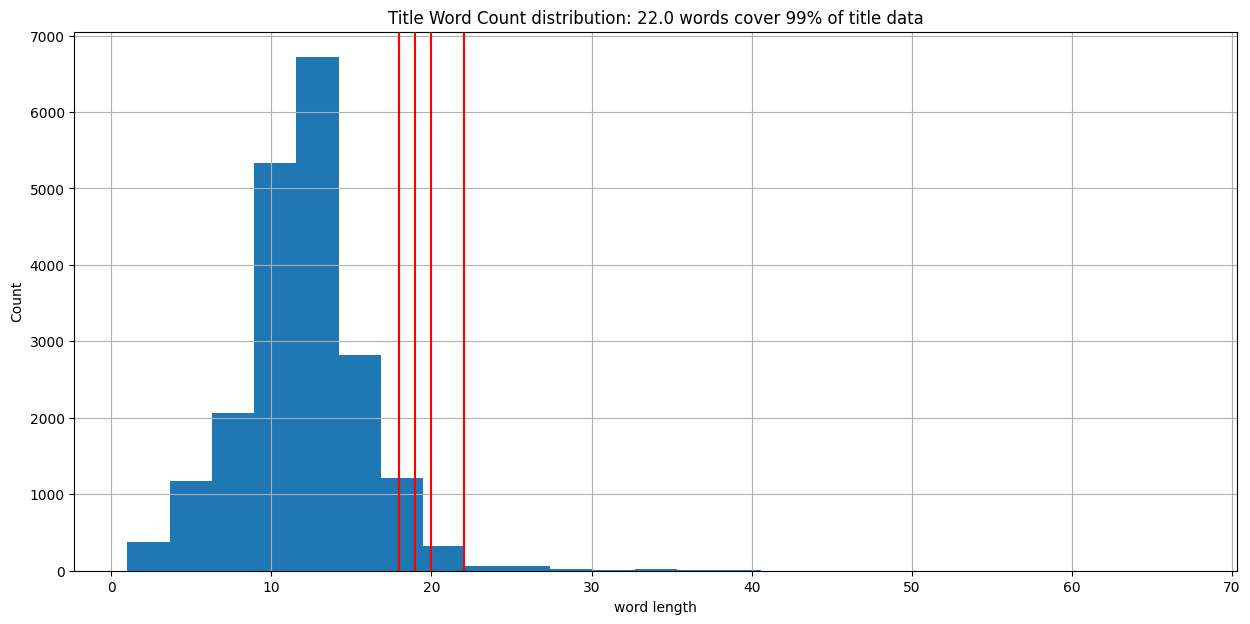

In [33]:
# Title Word Count distribution
plt.figure(figsize = (15,7))
plt.grid()
plt.hist(x = data.title_len, bins=25)
plt.xlabel('word length')
plt.ylabel('Count')
percent = 99
for i in range(95,100):
    plt.axvline(x = np.percentile(data.title_len, i), color = 'r', label = 'axvline - full height')
plt.title(f'Title Word Count distribution: {np.percentile(data.title_len, percent)} words cover {percent}% of title data')
plt.show()

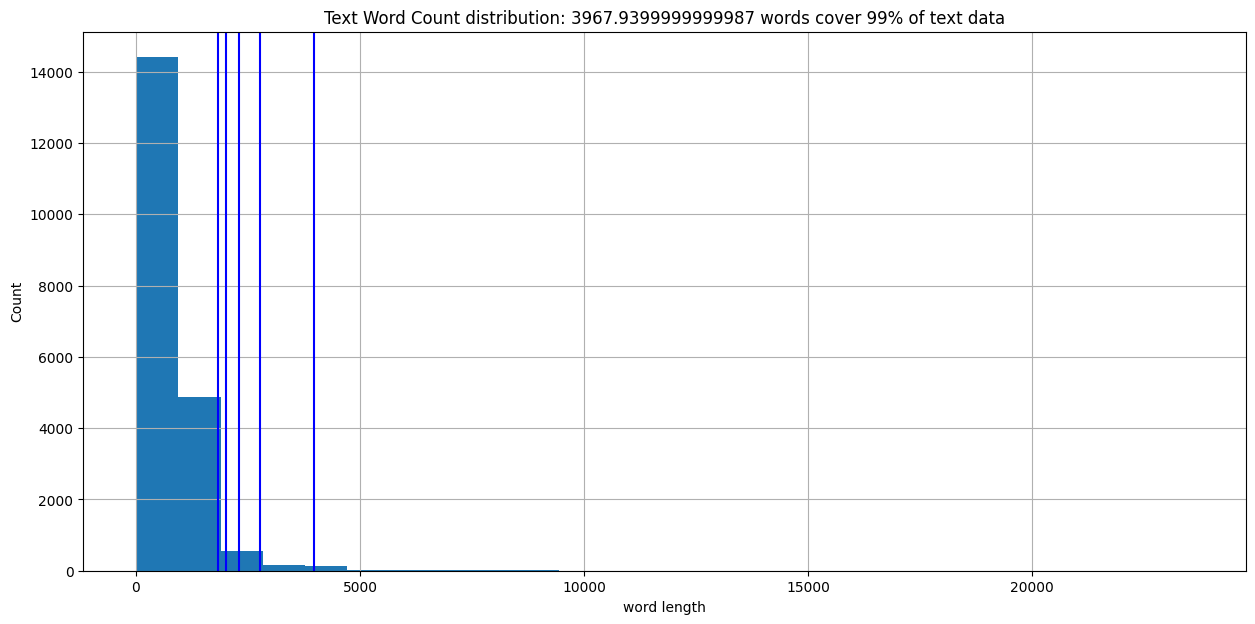

In [34]:
# Title Word Count distribution
plt.figure(figsize = (15,7))
plt.grid()
plt.hist(x = data.text_len, bins=25)
plt.xlabel('word length')
plt.ylabel('Count')
# plt.plot(x = , y = 0)
percent = 99
for i in range(95,100):
    plt.axvline(x = np.percentile(data.text_len, i), color = 'b', label = 'axvline - full height')
plt.title(f'Text Word Count distribution: {np.percentile(data.text_len, percent)} words cover {percent}% of text data')
plt.show()

so word lenghth upto 22 covers 99% of the dataset title
so word lenghth upto 4061 covers 99% of the dataset text

# Text Vectorization

In [35]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [36]:
s = data.text[11]
s

'the bbc produced spoof on the real housewives tv programmes which has comedic islamic state twist has been criticised by leftists and muslims who claim the sketch is offensive the bbc released the trailer earlier this week and were immediately slammed by those on the left and muslims who thought that making fun of the brides of members of the terror group was out of the bounds of conventional humour the sketch is part of new programme called revolting written by jolyon rubinstein and heydon prowse which according to the bbc is satirising the state of the nation lololol pic twitter raheem kassam raheemkassam january the bbc facebook page was inundated with criticism one user wrote m mortified that the bbc had produced such programme this is simply bad taste the fact it is comedy makes it even more worrying that humour should be associated with the actions of isis is this really what tv licenses are funding others took different point of view including muslim saying as muslim find this 

In [37]:
from scipy import sparse
tfidf = TfidfVectorizer()
ddd = tfidf.fit_transform(np.array([s]))
ddd

<1x244 sparse matrix of type '<class 'numpy.float64'>'
	with 244 stored elements in Compressed Sparse Row format>

In [38]:
# tfidf.get_feature_names()

In [39]:
data[['text','title','label']]

,text,title,label
0,house dem aide we did not even see comey lette...,house dem aide we did not even see comey lette...,1
1,ever get the feeling your life circles the rou...,flynn hillary clinton big woman on campus brei...,0
2,why the truth might get you fired october the ...,why the truth might get you fired,1
3,videos civilians killed in single us airstrike...,civilians killed in single us airstrike have ...,1
4,print an iranian woman has been sentenced to s...,iranian woman jailed for fictional unpublished...,1
...,...,...,...
20795,rapper i unloaded on black celebrities who met...,rapper i trump poster child for white supremacy,0
20796,when the green bay packers lost to the washing...,n l playoffs schedule matchups and odds the ne...,0
20797,the macy of today grew from the union of sever...,macy is said to receive takeover approach by h...,0
20798,nato russia to hold parallel exercises in balk...,nato russia to hold parallel exercises in balkans,1


# Helper functions

In [40]:
# Function to evaluate: accuracy, precision, recall, f1-score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import datetime


def calculate_results(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall and f1 score of a binary classification model.
  Args:
      y_true: true labels in the form of a 1D array
      y_pred: predicted labels in the form of a 1D array
  Returns a dictionary of accuracy, precision, recall, f1-score.
  """
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1 score using "weighted average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results

In [41]:
def create_tensorboard_callback(dir_name, experiment_name):
    """
    Creates a TensorBoard callback instand to store log files.
    Stores log files with the filepath:
    "dir_name/experiment_name/current_datetime/"
    Args:
    dir_name: target directory to store TensorBoard log files
    experiment_name: name of experiment directory (e.g. efficientnet_model_1)
    """
    log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(
        log_dir=log_dir
    )
    print(f"Saving TensorBoard log files to: {log_dir}")
    return tensorboard_callback


# Spliting data

In [42]:
xtrain, xtest, ytrain, ytest = train_test_split(data[['title', 'text']], data['label'], test_size = .1, random_state=3, stratify = data.label)

In [43]:
print('xtrain: ', xtrain.shape)
print('ytrain: ', ytrain.shape)
print('xtest: ', xtest.shape)
print('ytest: ', ytest.shape)

xtrain:  (18182, 2)
ytrain:  (18182,)
xtest:  (2021, 2)
ytest:  (2021,)


# Baseline : Model 0

In [44]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline

In [45]:
model0 = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', MultinomialNB())
])

#fit model
model0.fit(xtrain.title.to_list(), ytrain.to_list())


Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [46]:
ytrue0 = ytest.to_list()
ypred0 = model0.predict(xtest.title.to_list())

In [47]:
calculate_results(ytrue0, ypred0)

{'accuracy': 86.7887184562098,
 'precision': 0.8776860580323497,
 'recall': 0.867887184562098,
 'f1': 0.8666621593840541}

# Token Vectorization

In [48]:
from tensorflow.keras.layers import TextVectorization, Conv1D, GlobalMaxPooling1D, GlobalAveragePooling1D
from tensorflow.keras import layers
import tensorflow as tf
from tensorflow import keras

In [49]:
# number of unique words in dataset
# %%time
all_title_words_list = [words.split() for words in xtrain.title]
all_title_words = set(num for sublist in all_title_words_list for num in sublist)
print('total token in titles: ',len(all_title_words))

all_text_words_list = [words.split() for words in xtrain.text]
all_text_words = set(num for sublist in all_text_words_list for num in sublist)
print('total token in text: ',len(all_text_words))

all_words_combined_list = all_text_words_list + all_title_words_list
all_words_combined = set(num for sublist in all_words_combined_list for num in sublist)

print('total token combined: ',len(all_words_combined))

total token in titles:  19905
total token in text:  140458
total token combined:  140868


In [50]:
# output_sequence_length
percent_of_the_data_to_cover = 99
output_sequence_len_title = int(np.percentile(data.title_len, percent_of_the_data_to_cover))
print('output_sequence_len_title: ',output_sequence_len_title)
output_sequence_len_text = int(np.percentile(data.text_len, percent_of_the_data_to_cover))
print('output_sequence_len_text: ',output_sequence_len_text)

output_sequence_len_title:  22
output_sequence_len_text:  3967


we do not want every word to tokenize , there happens to be alot of less occuring words that we do not want. Thats why we will substract 500 words

In [51]:
max_token_title = len(all_title_words) - 2500          #number of words to tokenize -500 as we do not want every word to tokenize 
print('max_token_title: ',max_token_title)
max_token_text = len(all_text_words) -100_000     # minus 100000 because there are alot of useless words in the data
print('max_token_text: ',max_token_text)

max_token_title:  17405
max_token_text:  40458


### VECTORIZER FOR TITLE


In [52]:
# VECTORIZER FOR TITLE
title_text_vectorizer = TextVectorization(max_tokens=max_token_title, 
                                          output_sequence_length=output_sequence_len_title,
                                          pad_to_max_tokens = True)

2022-11-11 12:48:19.667506: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [53]:
# Adapt text vectorizer to training titles
# %%time
title_text_vectorizer.adapt(xtrain.title.to_list())

In [54]:
# how many words are there
total_title_words =  len(title_text_vectorizer.get_vocabulary())
print('total no. of words: ', total_title_words)
print('5 Most frequent words', title_text_vectorizer.get_vocabulary()[:5])
print('5 Least frequent words', title_text_vectorizer.get_vocabulary()[-5:])

total no. of words:  17405
5 Most frequent words ['', '[UNK]', 'the', 'new', 'york']
5 Least frequent words ['ehemalige', 'egyptology', 'egregious', 'egotism', 'egot']


In [55]:
# Test out text vectorizer
import random
target_title_sentence = random.choice(xtest.title.to_list())
print(f"Text:\n{target_title_sentence}")
print(f"\nLength of text: {len(target_title_sentence.split())}")
print(f"\nVectorized text:\n{title_text_vectorizer([target_title_sentence])}")

Text:
murderous hamas rejects trump classifying them as terrorists

Length of text: 8

Vectorized text:
[[14581  3040  1521     9     1   169    23   541     0     0     0     0
      0     0     0     0     0     0     0     0     0     0]]


### VECTORIZER FOR TEXT


In [56]:
# VECTORIZER FOR TEXT
text_text_vectorizer = TextVectorization(max_tokens=max_token_text, 
                                          output_sequence_length=output_sequence_len_text,
                                          pad_to_max_tokens = True)

**Note:** Here instead of Directly adapting to a list of string, we will convert it into 
tf.data.dataset to overcome fitting it the memory problem. It crashed the system if used a list. while a tf.data adjust according to the memory.

In [57]:
%%time
# Adapt text vectorizer to training text
train_text = tf.data.Dataset.from_tensor_slices(xtrain.text.to_list())
text_text_vectorizer.adapt(train_text)

CPU times: user 12.7 s, sys: 440 ms, total: 13.2 s
Wall time: 12.3 s


In [58]:
# how many words are there
total_text_words =  len(text_text_vectorizer.get_vocabulary())
print('total no. of words: ', total_text_words)
print('5 Most frequent words', text_text_vectorizer.get_vocabulary()[:5])
print('5 Least frequent words', text_text_vectorizer.get_vocabulary()[-5:])

total no. of words:  40458
5 Most frequent words ['', '[UNK]', 'the', 'to', 'of']
5 Least frequent words ['sequestered', 'septuagenarian', 'septembre', 'sentinelese', 'sensuous']


As we have seen above there are low frequency words that do not need to tokenize
as they occure less. so set max_token to less than actual unique words.

In [59]:
# Test out text vectorizer
import random
target_text_sentence = random.choice(xtest.text.to_list())
print(f"Text:\n{target_text_sentence[:200]}")
print(f"\nLength of text: {len(target_text_sentence.split())}")
print(f"\nVectorized text:\n{text_text_vectorizer([target_text_sentence])}")

Text:
massachusetts designated terrorist group cair demands synagogue cancel speakers who are pro israel anti islam the speakers include leading counter jihadists frank gaffney of investigative project on t

Length of text: 86

Vectorized text:
[[3007 4880  870 ...    0    0    0]]


In [60]:
## testing
title_text_vectorizer('foreign sec britain will be perfectly ok if eu refuses to make deal')

<tf.Tensor: shape=(22,), dtype=int64, numpy=
array([ 221, 5279,  591,   26,   35, 4618, 8912,   74,  502, 1031,    6,
        172,  171,    0,    0,    0,    0,    0,    0,    0,    0,    0])>

# Word embedding using GENSIM

In [61]:
xtrain0, xtest0, ytrain0, ytest0 = train_test_split(data[['title', 'text']], data['label'], test_size = .1, random_state=3, stratify = data.label)

print('xtrain: ', xtrain0.shape)
print('ytrain: ', ytrain0.shape)
print('xtest: ', xtest0.shape)
print('ytest: ', ytest0.shape)

xtrain:  (18182, 2)
ytrain:  (18182,)
xtest:  (2021, 2)
ytest:  (2021,)


Here we will be embedding the model on only text data because. the titles are mostly subset of the text corpus. Every word in titles comes form the text.

In [62]:
# create a list of lists of dataset
x_texts = data.text.apply(lambda x: str(x).split()).to_list()
print(len(x_texts))

20203


In [63]:
print(x_texts[0][:20]) # there are alot of words, we will just see 20 for now

['house', 'dem', 'aide', 'we', 'did', 'not', 'even', 'see', 'comey', 'letter', 'until', 'jason', 'chaffetz', 'tweeted', 'it', 'by', 'darrell', 'lucus', 'on', 'october']


In [64]:
DIM = 100
gen_embedd_model = gensim.models.Word2Vec(sentences=x_texts, vector_size = DIM, window=5, min_count=2)

In [65]:
len(gen_embedd_model.wv.key_to_index)

90545

In [89]:
gen_embedd_model.wv['the']

array([-1.11951959e+00,  4.08288062e-01, -6.09141827e-01,  6.13413036e-01,
       -1.16627073e+00,  3.80208302e+00, -9.98876691e-01, -2.20454192e+00,
        5.84824979e-01,  5.43815196e-01,  5.48457086e-01, -3.53820324e-02,
        2.57762170e+00, -1.32984206e-01,  3.82571667e-02,  3.35341990e-01,
        6.79754615e-02, -7.32453227e-01, -6.32285535e-01, -1.57051757e-01,
       -1.95845112e-01,  6.05520904e-01, -1.81574094e+00,  4.20977741e-01,
        8.06192577e-01, -1.36145309e-03,  1.73846364e+00,  1.81278393e-01,
       -2.94419676e-02, -4.40703481e-01,  1.02515352e+00,  1.02539206e+00,
       -1.08825363e-01, -2.32402638e-01,  2.15919685e+00, -1.95012999e+00,
        1.53344169e-01, -1.21478386e-01,  9.75363910e-01,  9.27806020e-01,
       -4.79756653e-01,  2.01201224e+00, -9.30773973e-01, -1.85682511e+00,
       -1.82331252e+00,  1.10766625e+00,  9.41607868e-04,  1.49450397e+00,
        9.63375866e-01, -3.92795444e-01,  2.49312967e-01,  9.96809721e-01,
        9.44557846e-01, -

In [67]:
gen_embedd_model.wv.similar_by_word('india')

[('japan', 0.8064728379249573),
 ('thailand', 0.7593681812286377),
 ('china', 0.7467932105064392),
 ('indonesia', 0.740390956401825),
 ('norway', 0.7370634078979492),
 ('asia', 0.7341105937957764),
 ('singapore', 0.7187834978103638),
 ('canada', 0.7107129096984863),
 ('mainland', 0.7026318907737732),
 ('australia', 0.7012481093406677)]

Gensim model already give us adjusted embedding of word in dataset that do not need to retrain in over DL model.

# Word Embedding

In [68]:
from tensorflow.keras.layers import Embedding

### Text embedding

In [108]:
total_text_words =  len(text_text_vectorizer.get_vocabulary())
print(total_text_words)

40458


In [109]:
def get_embedded_matrix(model, tokenizer):
    total_words = len(tokenizer.get_vocabulary())
    embed_matrix = np.zeros(shape = (total_words, DIM))
    
    for idx, word in enumerate(tokenizer.get_vocabulary()):
#         print(idx, word)
        if idx in [0,1]:  # because gensim embedding doesn't include `[UNK]` we have to leave it . 
            continue
        else:
            try:
                embed_matrix[idx] = model.wv[word]
            except KeyError:
                embed_matrix[idx] = np.zeros(shape=(DIM,))
    print('embed_matrix shape: ',embed_matrix.shape)
    return embed_matrix
        

In [110]:
text_embedded_matrix = get_embedded_matrix(gen_embedd_model, text_text_vectorizer)

embed_matrix shape:  (40458, 100)


In [111]:
text_embedding_layer = layers.Embedding(input_dim = total_text_words,
                           output_dim = DIM,
                           mask_zero = True,
                        weights= [text_embedded_matrix],
                          input_length=output_sequence_len_text)

In [112]:
print('sentence: ', target_text_sentence[:100] ,end = '\n')
print('sentence len: ', len(target_text_sentence) ,end = '\n')

print('\n')
vectorized_sentence = text_text_vectorizer([target_text_sentence])
print('vectorized: ', vectorized_sentence)
print('\n')
embedded_sentence = text_embedding_layer(vectorized_sentence)
print('embedded shape', embedded_sentence.shape)
print('embedded: ', embedded_sentence[:,:5,:5]) #This is too long to print 


sentence:  massachusetts designated terrorist group cair demands synagogue cancel speakers who are pro israel a
sentence len:  530


vectorized:  tf.Tensor([[3007 4880  870 ...    0    0    0]], shape=(1, 3967), dtype=int64)


embedded shape (1, 3967, 100)
embedded:  tf.Tensor(
[[[ 0.81941324  0.34800145  0.91580766  0.14329071 -0.35246173]
  [ 0.7246341   0.08278161  0.53863955  0.66494554 -0.37560084]
  [ 0.2433218  -1.7522945  -1.5017047  -1.3736368  -0.9711291 ]
  [-0.67829263  0.20899296  0.14515091 -1.4969027   0.2639953 ]
  [-0.33987355  0.13173091  0.3204634  -0.37406555 -0.27725467]]], shape=(1, 5, 5), dtype=float32)


### Title Embedding

In [121]:
# total_title_words =  len(title_text_vectorizer.get_vocabulary())
# print(total_title_words)

In [122]:
# title_embedding_layer = layers.Embedding(input_dim = total_title_words,
#                            output_dim = DIM,
#                            mask_zero = True,
#                         weights= [text_embedded_matrix],
#                           input_length=output_sequence_len_title)

In [123]:
# title_embedded_matrix = get_embedded_matrix(gen_embedd_model, title_text_vectorizer)

In [124]:
# title_embedding_layer = layers.Embedding(input_dim = total_title_words,
#                            output_dim = DIM,
#                            mask_zero = True,
#                             weights= [title_embedded_matrix],
#                           input_length=output_sequence_len_title)

In [125]:
# print('sentence: ', target_title_sentence ,end = '\n')
# print('sentence len: ', len(target_title_sentence) ,end = '\n')
# print('\n')
# vectorized_sentence = title_text_vectorizer([target_title_sentence])
# print('vectorized: ', vectorized_sentence)
# print('\n')
# embedded_sentence = title_embedding_layer(vectorized_sentence)
# print('embedded shape', embedded_sentence.shape)
# print('embedded: ', embedded_sentence)


# Creating `tf.Data`

In [ ]:
here

In [166]:
xtrain_texts = xtrain.text.apply(lambda x: str(x).split()).to_list()
xtest_texts = xtest.text.apply(lambda x: str(x).split()).to_list()


In [ ]:
# train tf.data
train_title = tf.data.Dataset.from_tensor_slices(xtrain.title.to_list())
train_text  = tf.data.Dataset.from_tensor_slices(xtrain_texts)
train_label = tf.data.Dataset.from_tensor_slices(ytrain)

# test tf.data
test_title = tf.data.Dataset.from_tensor_slices(xtest.title.to_list())
test_text  = tf.data.Dataset.from_tensor_slices(xtest_texts)
test_label = tf.data.Dataset.from_tensor_slices(ytest)


## Title dataset

In [114]:
train_title_dataset = tf.data.Dataset.zip((train_title, train_label))
test_title_dataset  = tf.data.Dataset.zip((test_title, test_label))

## Text dataset

In [116]:
train_text_dataset = tf.data.Dataset.zip((train_text, train_label))
test_text_dataset  = tf.data.Dataset.zip((test_text, test_label))

In [137]:
print(train_text_dataset)

<ZipDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>


## Title + Text dataset

In [115]:
train_features = tf.data.Dataset.from_tensor_slices((xtrain.title.to_list(), xtrain.text.to_list()))
train_dataset  = tf.data.Dataset.zip((train_features, train_label))

test_features = tf.data.Dataset.from_tensor_slices((xtest.title.to_list(), xtest.text.to_list()))
test_dataset  = tf.data.Dataset.zip((test_features, test_label))

In [103]:
modela = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', MultinomialNB())
])

#fit model
modela.fit(xtrain.title.to_list(), ytrain)
# model0.fit(sss, ytrain.to_list())
ytruea = ytest.to_list()
ypreda = model0.predict(xtest.title.to_list())

calculate_results(ytruea, ypreda)

{'accuracy': 86.7887184562098,
 'precision': 0.8776860580323497,
 'recall': 0.867887184562098,
 'f1': 0.8666621593840541}

In [141]:
# Visualizing the data
for i,j in train_text_dataset.take(1):
    print(i,j)
    break

tf.Tensor(b'former dea prescription head drops bombshell congress protects big pharma fuels opioid crisis source claire bernish congress would rather protect the profits of pharmaceutical companies than the health of those addicted to dangerous opioid drugs says former head of the dea responsible for preventing abuse of medications joseph rannazzisi former deputy assistant administrator at the s drug enforcement agency asserts big pharma and its lobbyists have stranglehold on legislators in congress and have engineered the protection of billion per year industry over the health of american citizens according to report from the guardian congress would rather listen to people who had profit motive rather than public health and safety motive he said according to the outlet as long as the industry has this stranglehold through lobbyists nothing going to change rannazzisi explained lobbyists have spent millions thwarting legislative and policy efforts to provide guidelines for reducing the 

In [105]:
BATCH_SIZE = 32

In [142]:
# prefetching 
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_title_dataset = train_title_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_title_dataset = test_title_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_text_dataset = train_text_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_text_dataset = test_text_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Model 1

In [162]:
def line_breaker(x):
# aa = tf.constant(ss)
    return tf.strings.split(x)

In [164]:
ss = 'this is a string'
line_breaker(ss)

<tf.Tensor: shape=(4,), dtype=string, numpy=array([b'this', b'is', b'a', b'string'], dtype=object)>

In [165]:
input1 = keras.Input(shape = (1), dtype = tf.string)
print('Input shape: ',input1.shape)

# tokenize = text_text_vectorizer(input1)
# print('tokenize shape: ', tokenize.shape)

x = layers.Lambda(tf.strings.split(input1))

embedd = text_embedding_layer(x)
print('embedded shape: ',embedd.shape)

# a conv1d layer
x = layers.Conv1D(32, 5, 1, activation='relu')(embedd)
x = layers.Dropout(.3)(x)
x = layers.Dense(32, activation='relu')(x)
output1 = layers.Dense(1, activation='relu')(x)

#compile
model1 = keras.Model(inputs = input1, outputs = output1)

# model1 = keras.Sequential()
# model1.add(keras.Input(shape = (1,), dtype = tf.string))
# model1.add(text_text_vectorizer)
# model1.add(text_embedding_layer)
# model1.add(layers.Conv1D(32, 5, 1, activation='relu'))
# # model1.add(layers.Dropout(.3))
# model1.add(layers.Dense(32, activation='relu'))
# model1.add(layers.Dense(1))

#compile
model1.compile(loss = tf.keras.losses.BinaryCrossentropy(),
              optimizer = tf.keras.optimizers.Adam(learning_rate = .00001),
              metrics = ['accuracy'])

Input shape:  (None, 1)


TypeError: unsupported callable

In [ ]:
EPOCHS = 50
print(int(.9* (len(train_text_dataset)/EPOCHS)))
print(len(train_text_dataset))

In [145]:
hist1 = model1.fit(train_text_dataset, epochs = EPOCHS,
#                       steps_per_epoch = int(.9* (len(train_title_dataset)/EPOCHS)),
                   steps_per_epoch = 10,   
                   validation_steps = int(.2* (len(train_text_dataset)/EPOCHS)),
                      validation_data=test_text_dataset,
                      callbacks = [create_tensorboard_callback('tb','model1')]
                    )

Saving TensorBoard log files to: tb/model1/20221111-133038
Epoch 1/50
10/10 [==============================] - 6s 541ms/step - loss: 4.7357 - accuracy: 0.5278 - val_loss: 4.1200 - val_accuracy: 0.5311
Epoch 2/50
10/10 [==============================] - 4s 450ms/step - loss: 3.8797 - accuracy: 0.5371 - val_loss: 3.9093 - val_accuracy: 0.5311
Epoch 3/50
10/10 [==============================] - 4s 451ms/step - loss: 3.9776 - accuracy: 0.5061 - val_loss: 3.8029 - val_accuracy: 0.5311
Epoch 4/50
10/10 [==============================] - 4s 443ms/step - loss: 4.2012 - accuracy: 0.4721 - val_loss: 3.7312 - val_accuracy: 0.5311
Epoch 5/50
10/10 [==============================] - 4s 437ms/step - loss: 3.4152 - accuracy: 0.5648 - val_loss: 3.6774 - val_accuracy: 0.5311
Epoch 6/50
10/10 [==============================] - 4s 440ms/step - loss: 3.8239 - accuracy: 0.5030 - val_loss: 3.6341 - val_accuracy: 0.5311
Epoch 7/50
10/10 [==============================] - 5s 464ms/step - loss: 3.6881 - accura

KeyboardInterrupt: 

# Modeln


In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.layers import GlobalAveragePooling1D, GlobalMaxPooling1D

In [ ]:
input1 = layers.Input(shape = (1,), dtype = tf.string)
token = title_text_vectorizer(input1)
embed = title_embedder(token)
x = layers.LSTM(32,return_sequences=True)(embed)
x = layers.LSTM(32,return_sequences=True)(x)
title_out = GlobalAveragePooling1D()(x)
print('title output shape: ',title_out.shape)

input2 = layers.Input(shape = (1,), dtype= tf.string)
token2 = text_text_vectorizer(input2)
embed2 = text_embedder(token2)
x = layers.LSTM(32,return_sequences=True)(embed2)
x = layers.LSTM(32,return_sequences=True)(x)
text_out = GlobalAveragePooling1D()(x)
print('text output shape: ',text_out.shape)

concat = layers.Concatenate()([title_out, text_out])
print('concatenated shape: ',concat.shape)

x = layers.Dropout(.3)(concat)
x = layers.Dense(128, activation = 'relu')(x)
x = layers.Dense(128, activation = 'relu')(x)
outputs = layers.Dense(1, activation = 'sigmoid')(x)

modeln = keras.Model(inputs = [input1,input2], outputs = outputs)

#COMPILE
modeln.compile(loss = keras.losses.SparseCategoricalCrossentropy(),
               optimizer = keras.optimizers.Adam(),
               metrics = ['accuracy'])

title output shape:  (None, 32)
text output shape:  (None, 32)
concatenated shape:  (None, 64)


In [ ]:
EPOCHS = 10
len(train_dataset), len(test_dataset)

(569, 64)

In [ ]:
historyn = modeln.fit(train_dataset, epochs = EPOCHS,
                      steps_per_epoch = int(.3* (len(train_dataset)/EPOCHS)),
                      validation_steps = int(.2* (len(test_dataset)/EPOCHS)),
                      validation_data=test_dataset,
                      callbacks = [create_tensorboard_callback('tb','model1')]
                    )

Saving TensorBoard log files to: tb/model1/20221110-214013
Epoch 1/10
28/28 [==============================] - 92s 3s/step - loss: nan - accuracy: 0.5246 - val_loss: nan - val_accuracy: 0.4688
Epoch 2/10
28/28 [==============================] - 13s 493ms/step - loss: nan - accuracy: 0.5134 - val_loss: nan - val_accuracy: 0.4688
Epoch 3/10
20/28 [====================>.........] - ETA: 21s - loss: nan - accuracy: 0.5063

KeyboardInterrupt: 

In [ ]:
loss = history1.history['loss']
val_loss = history1.history['val_loss']

accuracy = history1.history['accuracy']
val_accuracy = history1.history['val_accuracy']

# print(val_accuracy)
plt.figure(figsize = (25,7))

plt.subplot(1,2,1)
plt.grid(True)
plt.plot(np.arange(len(loss)), loss, 'r', label='Training loss')
plt.plot(np.arange(len(val_loss)), val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend()

plt.subplot(1,2,2)
plt.grid(True)
plt.plot(np.arange(len(accuracy)), accuracy, 'r', label='Training accuracy')
plt.plot(np.arange(len(val_accuracy)), val_accuracy, 'bo', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accracy Value')
plt.legend()

plt.show()